In [53]:
import numpy as np
import os
import glob
import torch
import matplotlib.image as mpimg
from pathlib import Path
import matplotlib.pyplot as plt
from skimage import transform
from sklearn.model_selection import train_test_split
data_path=Path('/Users/maksimtrebusinin/Desktop/Cancer_data')
list_dir=os.listdir(data_path)[1:]
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import time
from torch.utils.data import DataLoader, TensorDataset

In [2]:
X=list()
y=[0]*4000
index=0
for i, column_name in enumerate(list_dir):
    for img_path in glob.iglob(os.path.join(data_path, column_name, '*')):
        X.append(np.asarray(mpimg.imread(img_path)))
        y[index]=i
        index+=1
#0 is Healthy
#1 is Melanoma
#2 is Bascal cell carcioma
#3 is Squamous cell carcinoma
y=np.array(y)
transfrom_X=[transform.resize(image, (159,159,3)) for image in X]

In [16]:
# train and test selections
X_train, X_test, y_train, y_test = train_test_split(transfrom_X, y, test_size=0.25, stratify=y,
                                                    random_state=42)
X_train_tensor=torch.FloatTensor(X_train)
X_test_tensor=torch.FloatTensor(X_test)
y_train_tensor=torch.from_numpy(y_train)
y_test_tensor=torch.from_numpy(y_test)

X_train_tensor=X_train_tensor.reshape(3000, 3, 159, 159)
X_test_tensor=X_test_tensor.reshape(1000, 3, 159, 159)

/var/folders/jk/827xc8pj2fg1hy5mtf1fl1xh0000gn/T/ipykernel_59079/1508546652.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  X_train_tensor=torch.FloatTensor(X_train)


In [51]:
class CancerNet(torch.nn.Module):
    def __init__(self):
        super(CancerNet, self).__init__()

        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=30, kernel_size=4)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.act1 = torch.nn.ReLU()

        self.conv2 = torch.nn.Conv2d(in_channels=30, out_channels=60, kernel_size=3, padding=1)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.act2 = torch.nn.ReLU()

        self.conv3 = torch.nn.Conv2d(in_channels=60, out_channels=120, kernel_size=2)
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.act3 = torch.nn.ReLU()

        self.conv4 = torch.nn.Conv2d(in_channels=120, out_channels=80, kernel_size=3, padding=1)
        self.pool4 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.act4 = torch.nn.ReLU()

        self.conv5 = torch.nn.Conv2d(in_channels=80, out_channels=30, kernel_size=3, padding=1)
        self.act5 = torch.nn.ReLU()

        # Добавляем Dropout после последней активации перед полносвязным слоем
        self.dropout1 = torch.nn.Dropout(p=0.5)  # 50% случайных обнулений

        self.fc1 = torch.nn.Linear(9*9*30, 200)
        self.act6 = torch.nn.ReLU()
        self.dropout2 = torch.nn.Dropout(p=0.5)  # 50% Dropout на скрытом слое
        self.fc2 = torch.nn.Linear(200, 4)
        self.sm = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.act1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.act2(x)
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.act3(x)
        x = self.conv4(x)
        x = self.pool4(x)
        x = self.act4(x)
        x = self.conv5(x)
        x = self.act5(x)

        # Применяем Dropout после всех сверток и активаций
        x = self.dropout1(x)

        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))  # Преобразуем в вектор для подачи на fc

        x = self.fc1(x)
        x = self.act6(x)
        
        # Применяем Dropout после первого полносвязного слоя
        x = self.dropout2(x)

        x = self.fc2(x)
        return x

    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x


In [52]:
cancer_net=CancerNet()
loss=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(cancer_net.parameters(), lr=0.001)

In [47]:
def train_model(model, X_tr, y_tr, epoch, batch_size, opt, loss_fn):
    start_time = time.time()  # Начинаем отсчёт времени
    
    # Преобразуем данные в TensorDataset и используем DataLoader
    dataset = TensorDataset(X_tr, y_tr)
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Инициализация переменных для отслеживания потерь
    for ep in range(epoch):
        epoch_start_time = time.time()
        total_loss = 0.0  # Сумма потерь за одну эпоху
        model.train()  # Устанавливаем модель в режим тренировки

        for X_batch, y_batch in train_loader:
            opt.zero_grad()

            # Прогоняем батч через модель
            pred = model(X_batch)
            
            # Вычисляем потерю
            loss_value = loss_fn(pred, y_batch)
            total_loss += loss_value.item()

            # Обратное распространение и шаг оптимизации
            loss_value.backward()
            opt.step()

        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        hours, rem = divmod(epoch_duration, 3600)
        minutes, seconds = divmod(rem, 60)

        # Выводим статистику о потере и времени
        print(f"Epoch {ep + 1}/{epoch}, Loss: {total_loss / len(train_loader):.4f}, Time: {int(hours)}h {int(minutes)}m {int(seconds)}s")
    
    total_duration = time.time() - start_time  # Общее время тренировки
    hours, rem = divmod(total_duration, 3600)
    minutes, seconds = divmod(rem, 60)
    
    print(f"Training completed in: {int(hours)}h {int(minutes)}m {int(seconds)}s")

def predict(model, X_test):
    model.eval()  # Переводим модель в режим инференса (выключается Dropout и BatchNorm)
    with torch.no_grad():  # Отключаем вычисление градиентов
        X_test_tensor = torch.Tensor(X_test)  # Преобразуем тестовые данные в Tensor
        predictions = model(X_test_tensor)  # Получаем прогнозы
        return predictions

In [48]:
train_model(cancer_net, X_train_tensor,y_train_tensor, 10, 2, optimizer, loss)

Epoch 1/10, Loss: 911.9356, Time: 0h 0m 19s
Epoch 2/10, Loss: 876.6230, Time: 0h 0m 19s
Epoch 3/10, Loss: 847.8742, Time: 0h 0m 19s
Epoch 4/10, Loss: 807.8996, Time: 0h 0m 19s
Epoch 5/10, Loss: 782.9124, Time: 0h 0m 19s
Epoch 6/10, Loss: 743.1234, Time: 0h 0m 19s
Epoch 7/10, Loss: 708.5635, Time: 0h 0m 19s
Epoch 8/10, Loss: 668.7903, Time: 0h 0m 19s
Epoch 9/10, Loss: 631.5217, Time: 0h 0m 19s
Epoch 10/10, Loss: 600.7108, Time: 0h 0m 19s
Training completed in: 0h 3m 15s


In [27]:
def metrics(y_true, y_pred):
    print('Accuracy score:', accuracy_score(y_true, y_pred))
    mat=confusion_matrix(y_true, y_pred)
    sns.heatmap(mat, annot=True, fmt='d', cmap='coolwarm')

Accuracy score: 0.646


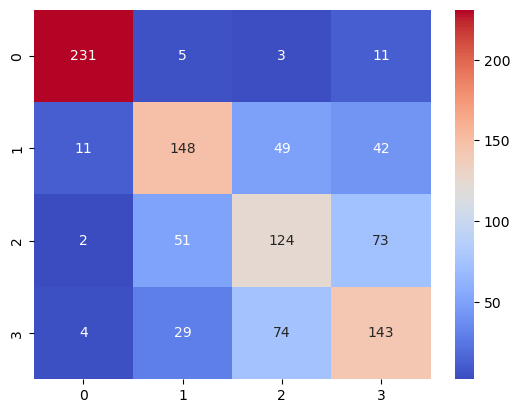

In [49]:
y_pred = predict(X_test_tensor)
metrics(np.array(y_test_tensor), y_pred)